In [30]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import coin

In [31]:
df = pd.read_excel('base_1D.xlsx', index_col='Data')

In [32]:
retorno, df_ln = coin.calc_ret_ln(df)

In [47]:
periodo = 150
base = retorno

# Regressão

## Precos as is

In [74]:
y = np.array(base.WINFUT.iloc[:periodo], dtype = float)
x = np.array(base.iloc[:periodo,1:], dtype = float)

In [80]:
coef = coin.reg_m(x,y).params

In [81]:
print(coin.reg_m(x,y).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     57.56
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           3.45e-19
Time:                        02:37:03   Log-Likelihood:                 481.44
No. Observations:                 150   AIC:                            -956.9
Df Residuals:                     147   BIC:                            -947.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -1.092      0.2

In [82]:
import plotly.express as px

fig = plt.figure(figsize=(30,30))
fig = px.scatter_3d(base, x='WDOFUT', y='WSPFUT', z='WINFUT')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

<Figure size 2160x2160 with 0 Axes>

# Resíduos

In [83]:
residuos = pd.DataFrame(columns=['residuos'])
residuos['residuos'] = coin.reg_m(x,y).resid_pearson

In [99]:
coin.coint_model(residuos)['ADF']

(-9.929492018168665,
 2.8478736839414906e-17,
 1,
 148,
 {'1%': -3.4753253063120644,
  '5%': -2.881274703275226,
  '10%': -2.5772928360116873},
 375.21680517396976)

<AxesSubplot:>

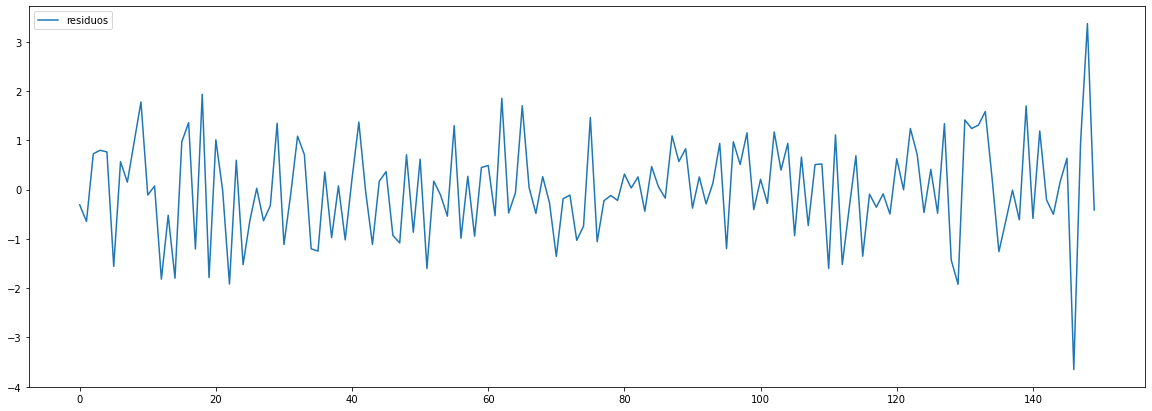

In [85]:
residuos.plot(figsize=(20,7))
#plt.axhline(y=1.5)
#plt.axhline(y=-1.5)

# Meia Vida

In [86]:
half_life, ar_res, delta, lagged = coin.half_life(residuos)
print('halflife: ', half_life)

halflife:  0.5787923387204297


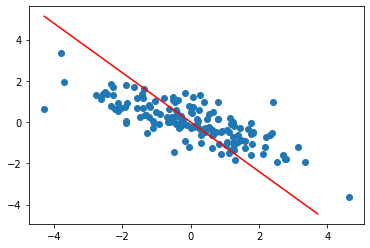

In [87]:
coin.get_scatter_plot(delta, lagged, ar_res)

## cointegrado backtest

In [122]:
difu = dict
cointegrado = 0
amostras = 0
for inicio in range(50, 600, 20):
    for periodo in np.arange(50,310, 10):
        y = np.array(base.WINFUT.iloc[inicio:(inicio+periodo)], dtype = float)
        x = np.array(base.iloc[inicio:(inicio+periodo),1:], dtype = float)

        residuos = pd.DataFrame(columns=['residuos'])
        residuos['residuos'] = coin.reg_m(x,y).resid_pearson
        
        test = coin.coint_model(residuos)['ADF'][0]
        difu = {'1%': -3.4753253063120644,'5%': -2.881274703275226,'10%': -2.5772928360116873}

        amostras+=1

        if difu['1%'] >= test:
            cointegrado +=1

print(cointegrado, amostras)

706 728


# Preditor

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 200)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [45]:
y_pred = regressor.predict(X_test)
print(y_pred)

[-0.01029565 -0.01573172 -0.02027437  0.00646258  0.01309615  0.01608009
  0.00025245  0.00950884 -0.02075139  0.00261566 -0.00194455 -0.00145496]


In [46]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.6081729831013999